In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,scale,StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm.notebook import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_data_list, rebalance_weight, plt_loss, plt_confusion, layer_activation


In [2]:
folderpath= ('/Users/stonyxiong/files/Research/dataset/Oil_mix_New1',
             '/Users/stonyxiong/files/Research/dataset/Oil_mix_New2',
             '/Users/stonyxiong/files/Research/dataset/Oil_mix_New3',
             '/Users/stonyxiong/files/Research/dataset/Oil_mix_New4')

materials = ['oil','water','vinegar']
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})
realmater = ["Oil","Oil/Water",'Oil/Vinegar']

In [3]:
data_list,labels = load_data_list(folderpath,materials,[1.8e4 , 1.8e4, 1.8e4, 1.8e4])
time_vec = pd.read_csv(f'{folderpath[0]}/time_vector.csv').values

In [4]:
seed = 43
set_seed(seed)
snapshot = np.array(data_list[0]+data_list[1] +data_list[2]).squeeze()
y = np.array(labels[0]+ labels[1] +labels[2]).reshape(-1,1)
snapshot_r = np.array(data_list[3]).squeeze()
y_r = np.array(labels[3]).reshape(-1,1)
print(snapshot.shape)
print(y.shape)
print(snapshot_r.shape)
print(y_r.shape)


(53997, 4096)
(53997, 1)
(17999, 4096)
(17999, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

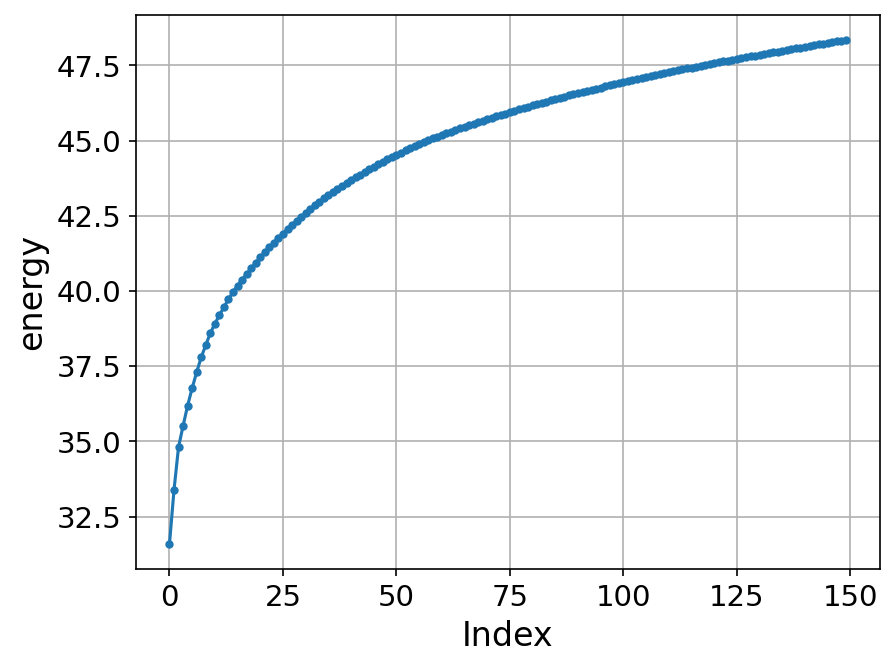

In [5]:
snapshot_train, snapshot_test, y_train, y_test = train_test_split(snapshot, y, test_size=0.001, random_state=42)
_,S,Vt = np.linalg.svd(snapshot_train,full_matrices=False)
V = Vt.T
energy = np.cumsum(S)/np.sum(S)*100
plt.figure(dpi=150)
plt.plot(energy[0:150],marker = 'o',linestyle='-',markersize = 3)
plt.xlabel('Index')
plt.ylabel('energy')
plt.grid(True)
plt.show

In [6]:
Vr = V[:,:36]
Xp_train = snapshot_train @ Vr
Xp_test = snapshot_test @ Vr
Xp_r = snapshot_r @ Vr
# Xp_train = snapshot_train
# Xp_test = snapshot_test
# Xp_r = snapshot_r

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/x0/9dpvqwcj6f3915c0b102q0bc0000gn/T/ipykernel_5660/2767660966.py:32: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time($\mu s$)")


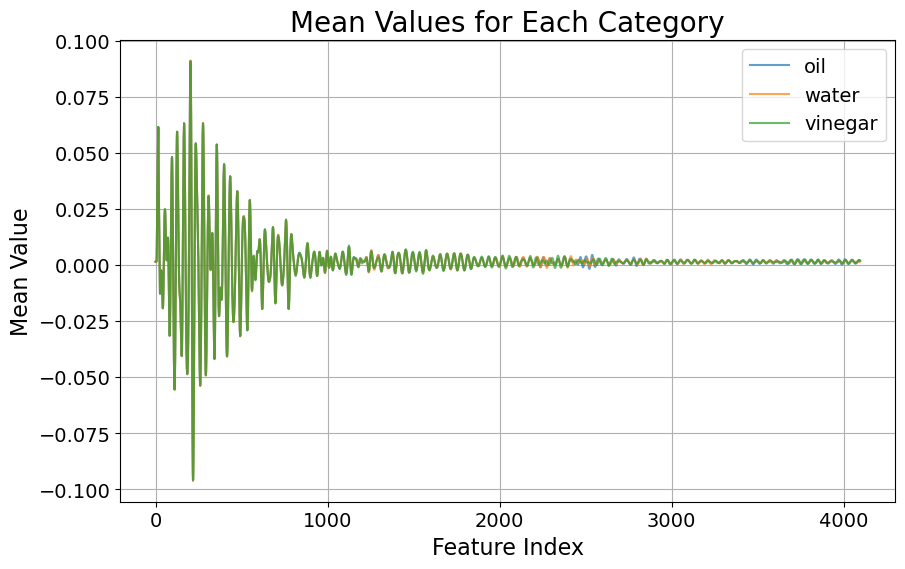

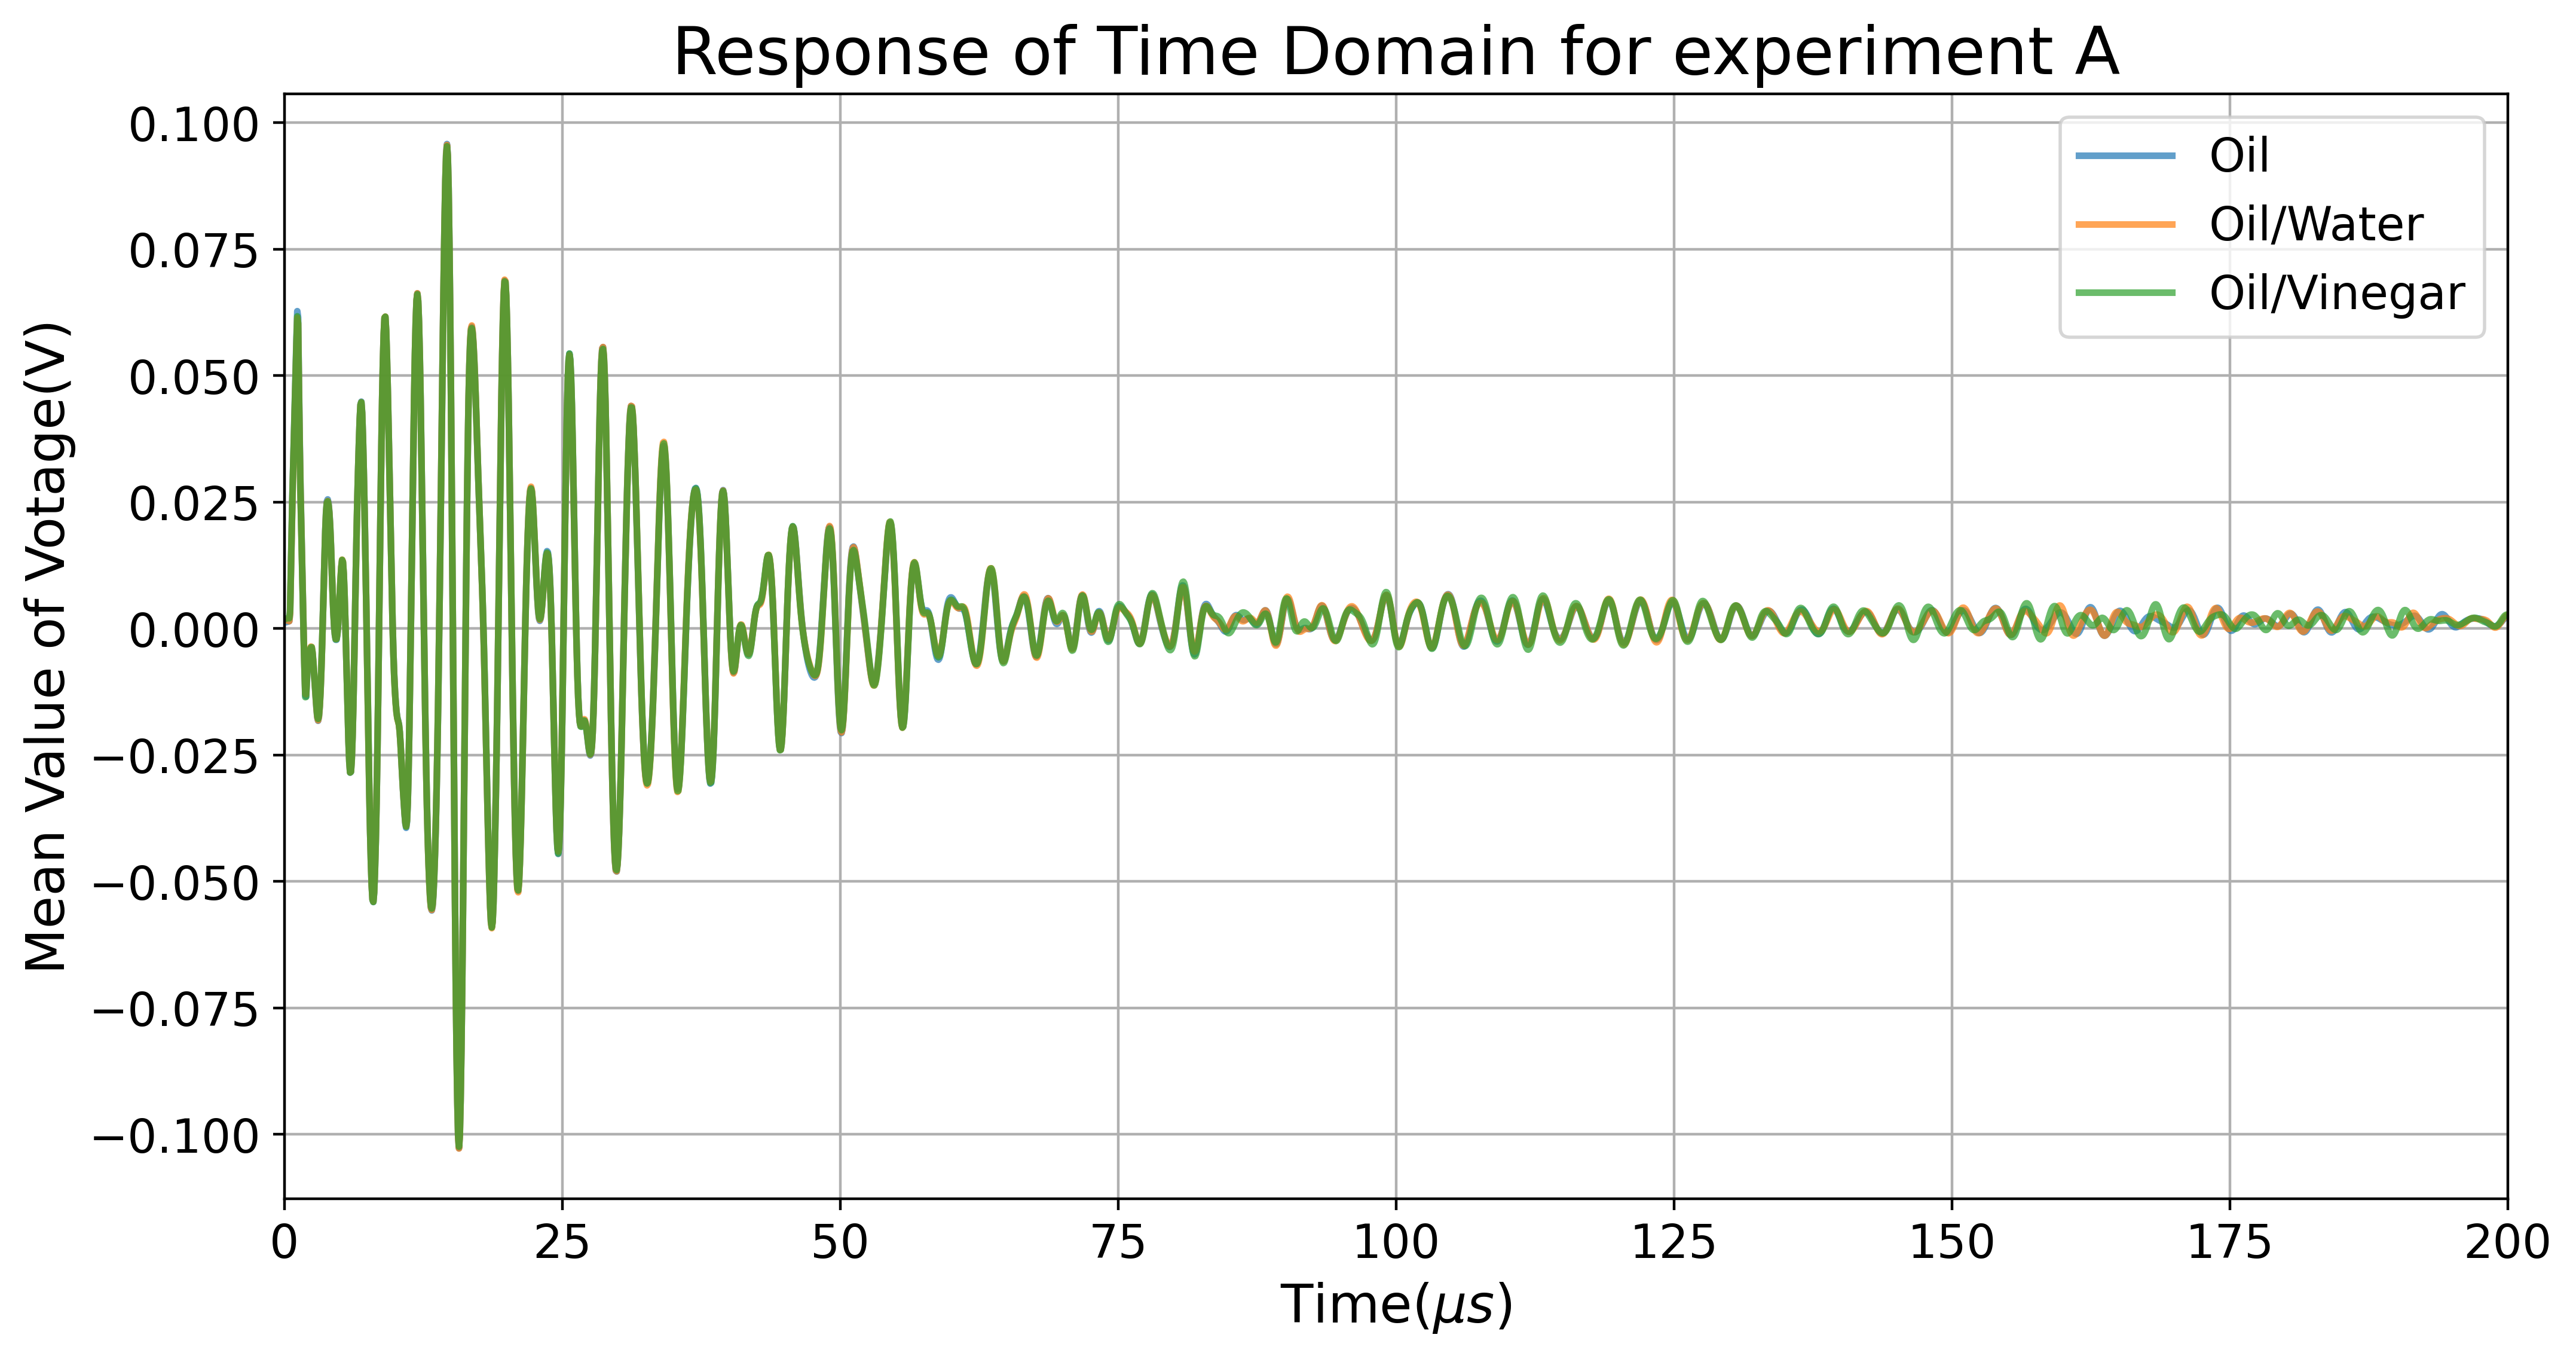

In [7]:
unique_labels = np.unique(y_train)
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
# for i, value in enumerate(points):
#     if i == 0:
#         plt.axvline(x=value, color='red', linestyle='--', label='points')
#     else:
#         plt.axvline(x=value, color='red', linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12,6),dpi=400)
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_r[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(time_vec*1e6,mean_values, label=f"{realmater[i]}",alpha = 0.7,linewidth = 2)
plt.xlim([0, 200])
plt.xlabel("Time($\mu s$)")
plt.ylabel("Mean Value of Votage(V)")
plt.title("Response of Time Domain for experiment A")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
device = torch.device(
    "cpu"
)
print("Using device:", device)

Using device: cpu


In [9]:
# Split data into train and test sets


# X_train = scale(Xp_train,axis=1)
# X_test = scale(Xp_test,axis=1)
# X_r_test = scale(Xp_r,axis=1)
scaler = StandardScaler()
# scaler = RobustScaler(unit_variance=False)
X_train = scaler.fit_transform(Xp_train)
X_test = scaler.transform(Xp_test)
X_r_test = scaler.transform(Xp_r)

scaler = MinMaxScaler(feature_range=(0, len(materials)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_r_test = scaler.transform(y_r)

X_r_ver,X_r_te, y_r_ver, y_r_te = train_test_split(X_r_test, y_r_test, train_size = 0.3,random_state=42)

print(X_r_ver.shape)
print(X_r_te.shape)

(5399, 36)
(12600, 36)


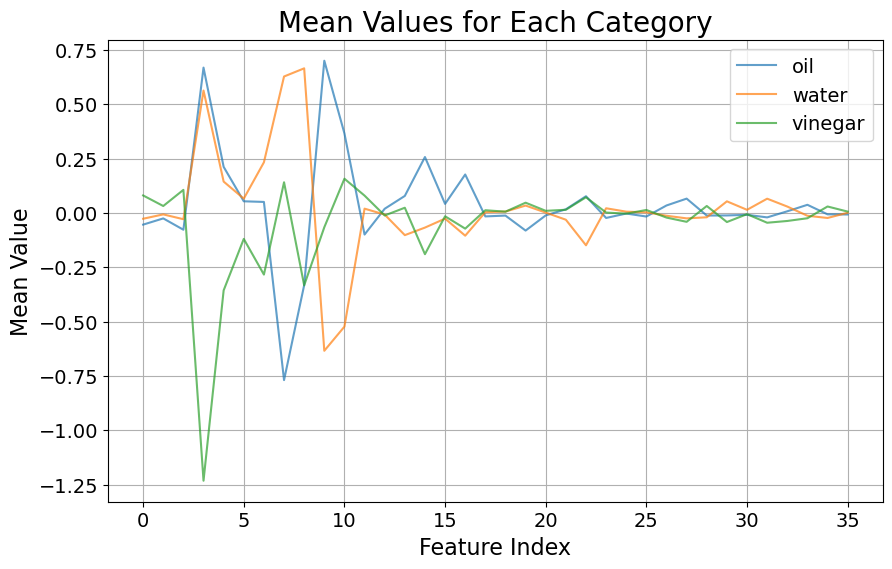

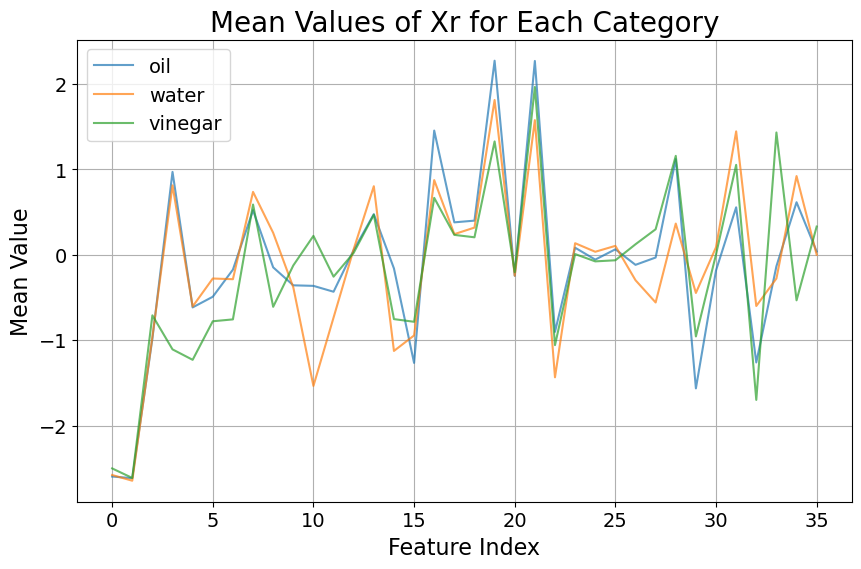

In [10]:
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r_test.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_r_test[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [11]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 36)
        self.fc2 = nn.Linear(36,24)
        self.fc3 = nn.Linear(24,16)
        self.fc4 = nn.Linear(16,len(materials))
        self.actf = nn.ELU()


    def forward(self, i):
        h1 = self.actf(self.fc1(i))
        h2 = self.actf(self.fc2(h1))
        h3 = self.actf(self.fc3(h2))
        o = self.fc4(h3)
        return o

set_seed(seed)

In [12]:
model = ANN_Model().to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=2e-5,weight_decay=1e-4)
# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_r_ver_tensor = torch.tensor(X_r_ver, dtype=torch.float32).to(device)
y_r_ver_tensor = torch.tensor(y_r_ver,dtype=torch.long).squeeze().to(device)
X_r_te_tensor = torch.tensor(X_r_te, dtype = torch.float32).to(device)
y_r_te_tensor = torch.tensor(y_r_te,dtype=torch.long).squeeze().to(device)

In [19]:
# 5. 训练模型
num_epochs = 24768
train_losses = []
verify_losses = []

pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_outputs = model(X_r_ver_tensor)
        verify_loss = criterion(verify_outputs, y_r_ver_tensor)
        verify_losses.append(verify_loss.item())
    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())

Training:   0%|          | 0/24768 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 1.0
Accuracy_train: 1.0
Confusion Matrix:
[[20  0  0]
 [ 0 15  0]
 [ 0  0 19]]


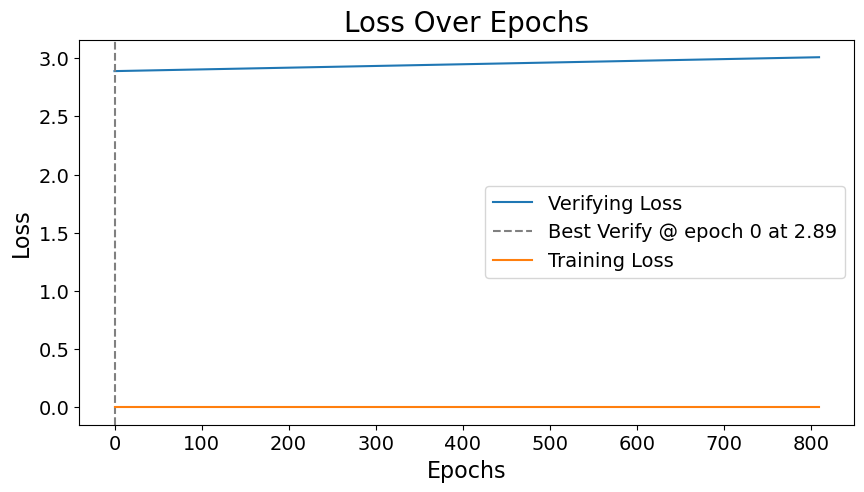

In [21]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses, verifying_losses =verify_losses)

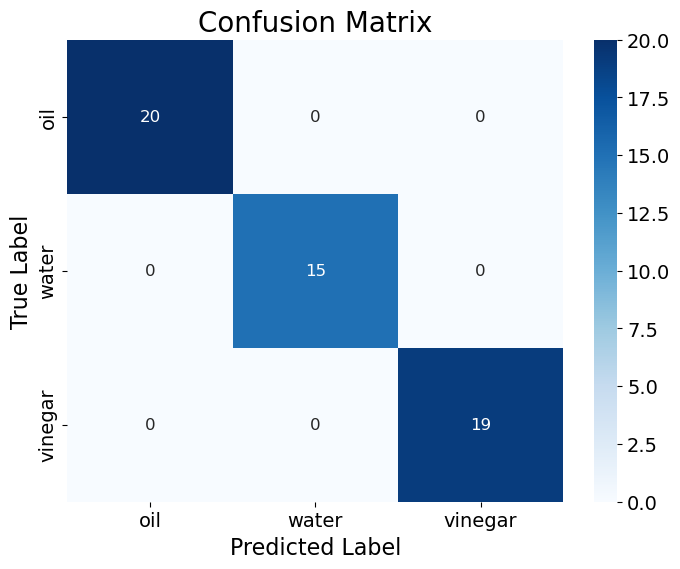

Accuracy: 1.0
              precision    recall  f1-score   support

         oil       1.00      1.00      1.00        20
       water       1.00      1.00      1.00        15
     vinegar       1.00      1.00      1.00        19

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [22]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [23]:
model.eval()
with torch.no_grad():
    r_ver_outputs = model(X_r_ver_tensor)
    _, predicted = torch.max(r_ver_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    ver_accuracy = accuracy_score(y_r_ver, predicted_np)
    ver_cm = confusion_matrix(y_r_ver, predicted_np)

Accuracy: 0.672531950361178


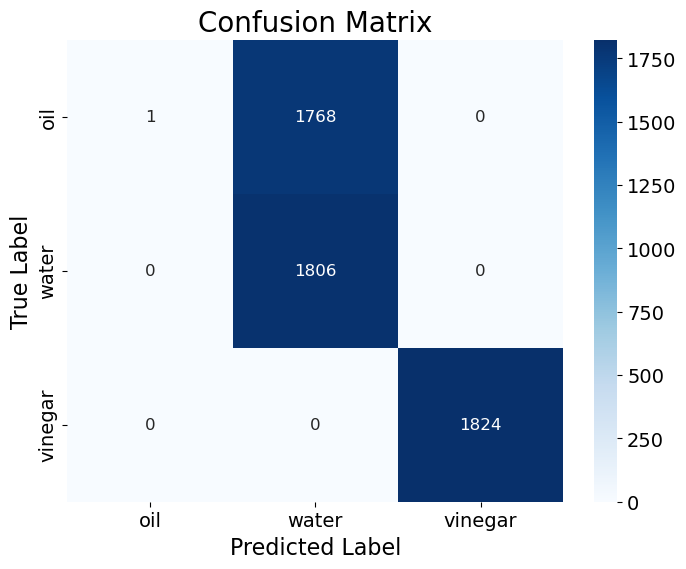

In [24]:
print(f'Accuracy: {ver_accuracy}')
plt_confusion(ver_cm,materials)

In [25]:
model.eval()
with torch.no_grad():
    r_te_outputs = model(X_r_te_tensor)
    _, predicted = torch.max(r_te_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_r_te, predicted_np)
    r_cm = confusion_matrix(y_r_te, predicted_np)

Accuracy: 0.6643650793650794


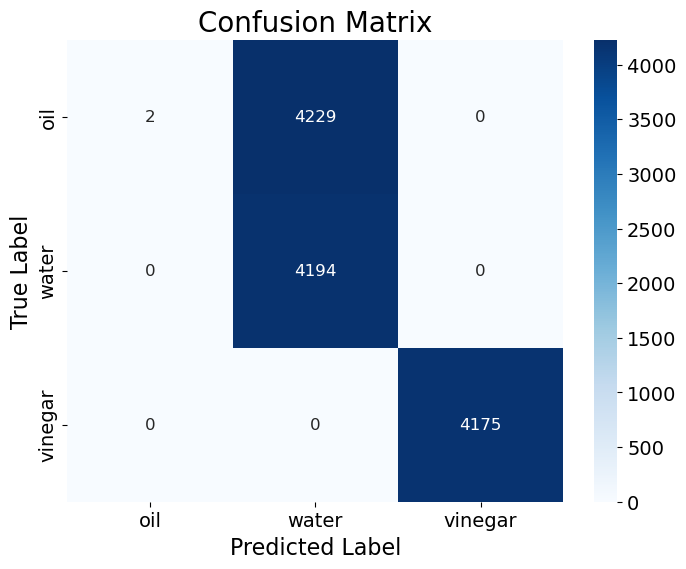

In [26]:
print(f'Accuracy: {r_accuracy}')
plt_confusion(r_cm,materials)

In [27]:
model.eval()
with torch.no_grad():
    logits = model(X_r_te_tensor.to(device))    # [N,2]
    
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
    all_scores = probs[:, 1].cpu().numpy()         # 正类概率 ∈ [0,1]
    all_labels = y_r_te  # shape (N,)

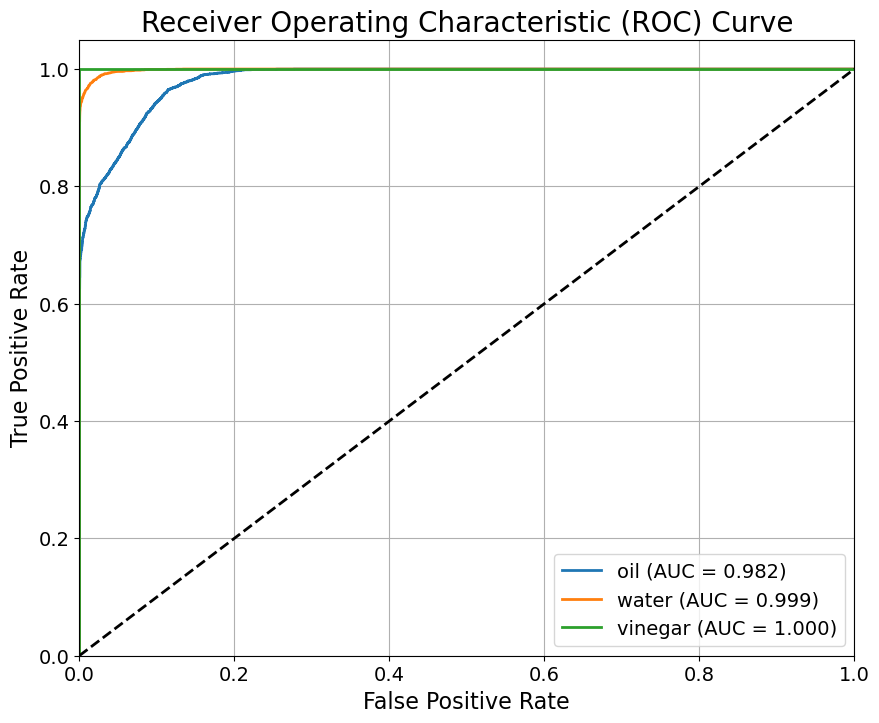

In [28]:
# One-vs-rest approach for ROC curves
n_classes = len(materials)  # 3 classes: oil, water, vinegar
fpr = {}
tpr = {}
roc_auc = {}

# Get prediction probabilities for each class
probs_np = probs.cpu().numpy()

# Calculate ROC curve and ROC area for each class
for i, class_name in enumerate(materials):
	# Convert to binary classification: current class vs rest
	y_binary = (y_r_te.flatten() == i).astype(int)
	fpr[class_name], tpr[class_name], _ = roc_curve(y_binary, probs_np[:, i])
	roc_auc[class_name] = roc_auc_score(y_binary, probs_np[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for class_name in materials:
	plt.plot(fpr[class_name], tpr[class_name], lw=2,
			 label=f'{class_name} (AUC = {roc_auc[class_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [29]:
layer_activation(model,device,X_r_test[:500,:],'fc2',100)

TypeError: layer_activation() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
save_dir = '/Users/stonyxiong/files/Research/models'
save_path = os.path.join(save_dir, 'oil_timedomain.pth')
torch.save(model.state_dict(), save_path)